In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from psfutil_1d import *

In [2]:
BAND = "H158"

psf_in = psf_single_slit(LDP[BAND])
psf_in_t = np.fft.rfft(np.fft.ifftshift(psf_in))
psf_inp = pixelate_psf(psf_in)
psf_inp_t = np.fft.rfft(np.fft.ifftshift(psf_inp))

# Let's try a wider target output PSF, and thus a wider weight field.
psf_out = psf_gaussian(SIGMA[BAND] * 2)
psf_out_t = np.fft.rfft(np.fft.ifftshift(psf_out))
weight_t = psf_out_t / psf_inp_t  # 9/7/2025
weight_t[NPIX::] = 0; weight_t.imag = 0
weight = np.fft.ifftshift(np.fft.irfft(weight_t, n=NTOT))

/tmp/ipykernel_20113/3225394591.py:11: RuntimeWarning: invalid value encountered in divide
  weight_t = psf_out_t / psf_inp_t  # 9/7/2025


In [3]:
ovl_ii = psf_overlap(psf_inp, psf_inp)  # A matrix.
ovl_io = psf_overlap(psf_out, psf_inp)  # -B/2 matrix.
ovl_oo = psf_overlap(psf_out, psf_out)  # Center is C.
print(C := ovl_oo[NTOT//2], square_norm(psf_out))

4.831145238312438 4.831145238312438


In [4]:
Sep5_plots = False

if Sep5_plots:
    fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)

    for func, label in zip([ovl_ii, ovl_io, ovl_oo],
                        ["In-in", "In-out", "Out-out"]):
        visualize_psf(axs, func, f"{label} overlap")

    format_and_show(fig, axs)

In [5]:
Amat = np.zeros((NPIX, NPIX))
Bmat = np.zeros((SAMP, NPIX))

for j in range(NPIX):
    Amat[j, j:min(j+(NPIX//2), NPIX)] =\
        ovl_ii[NTOT//2::SAMP][:min(NPIX//2, NPIX-j)]
    Amat[j:, j] = Amat[j, j:]

for i in range(SAMP):
    Bmat[i] = ovl_io[i::SAMP]

Ainv = np.linalg.inv(Amat)
Tmat = (Ainv @ Bmat.T).T

In [6]:
if Sep5_plots:
    fig, axs = plt.subplots(2, 2, figsize=(8.4, 6.0), sharex=True,
                            sharey="row", height_ratios=[2, 1.3])
    common = dict(orientation="vertical", pad=0.05)

    ax = axs[0, 0]; ax.set_title("$A$ matrix")
    show_matrix(fig, ax, Amat, **common)
    ax = axs[0, 1]; ax.set_title("$A^{-1}$ matrix")
    show_matrix(fig, ax, Ainv, **common)

    ax = axs[1, 0]; ax.set_title("$-B/2$ matrix")
    show_matrix(fig, ax, Bmat, aspect=13, **common)
    ax = axs[1, 1]; ax.set_title("$T$ matrix")
    show_matrix(fig, ax, Tmat, aspect=13, **common)

    axs[0, 0].set_ylabel("input pixel $j$")
    axs[1, 0].set_ylabel(r"output pixel $\alpha$")
    for ax in axs[1, :]: ax.set_xlabel("input pixel $i$")

    plt.tight_layout()
    plt.show()

/home/kailicao/fast_imcom_dev/psfutil_1d.py:125: RuntimeWarning: invalid value encountered in log10
  axs[1].plot(x, np.log10(psf))


9.2553418292729e-06


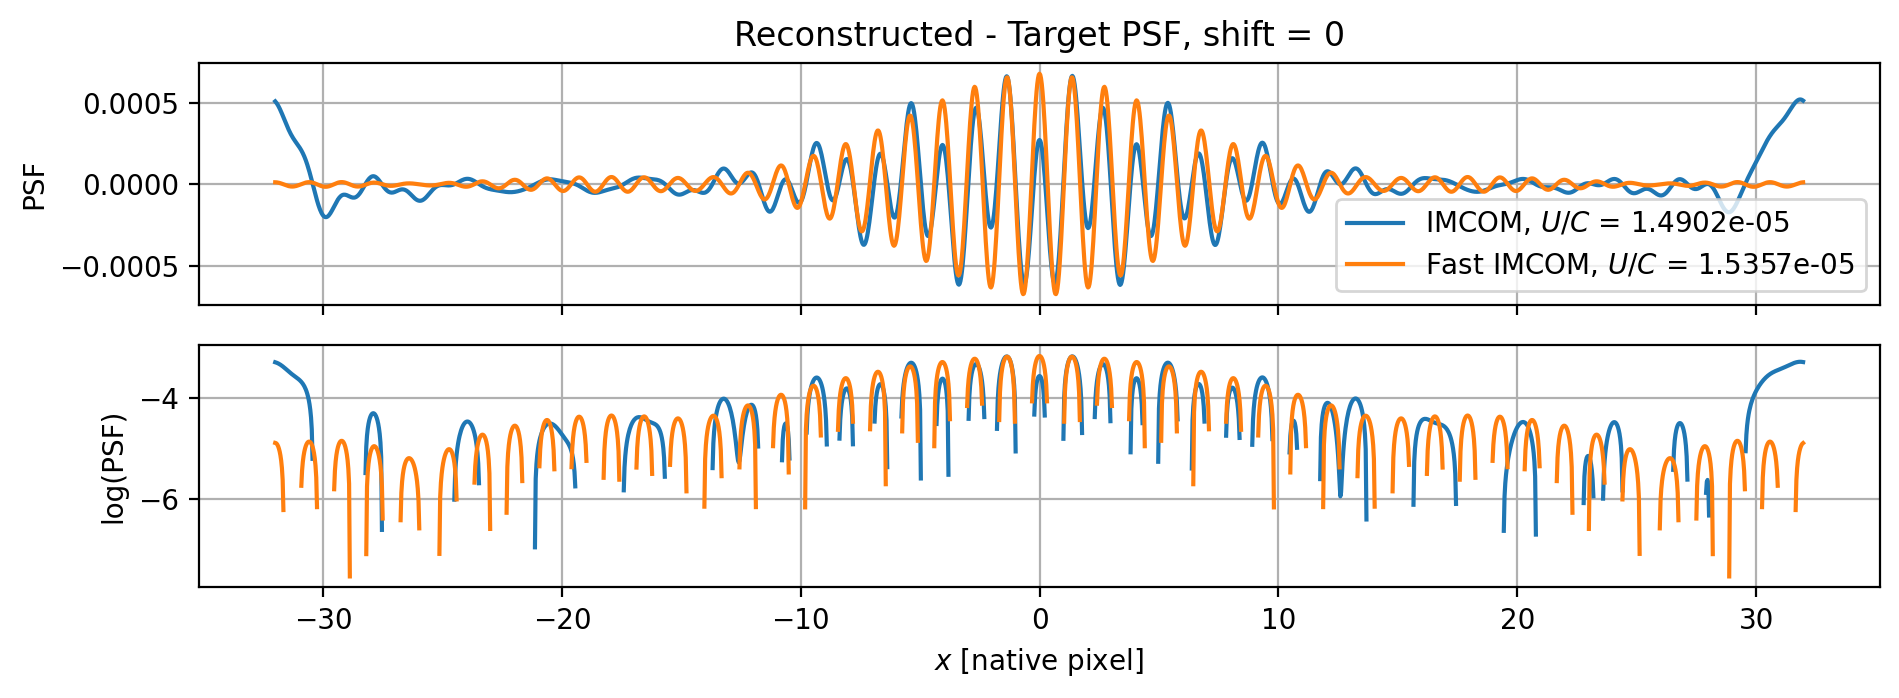

9.314881111555096e-06


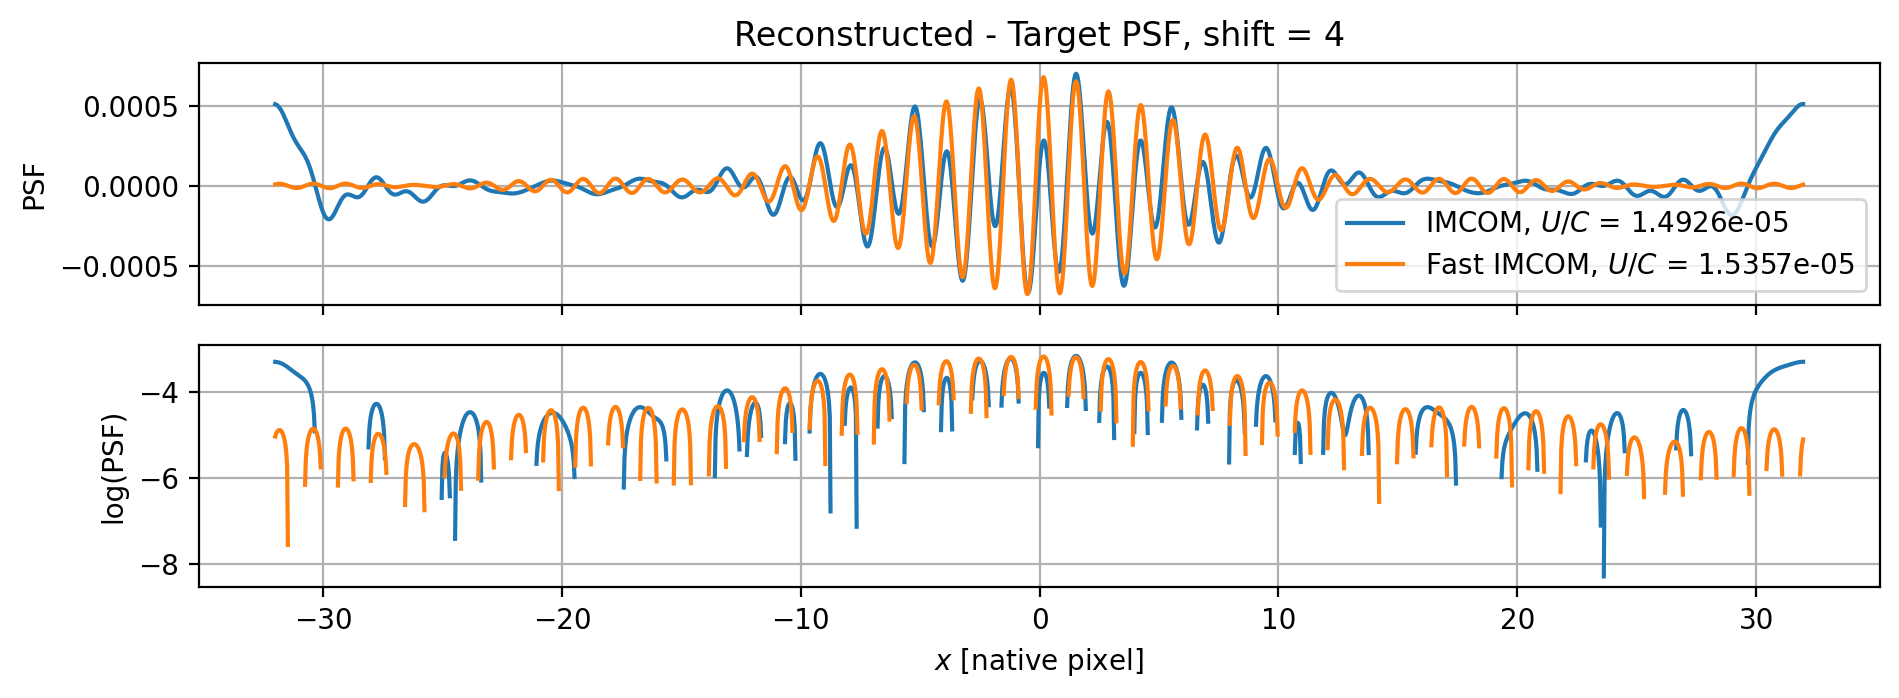

9.359459679503246e-06


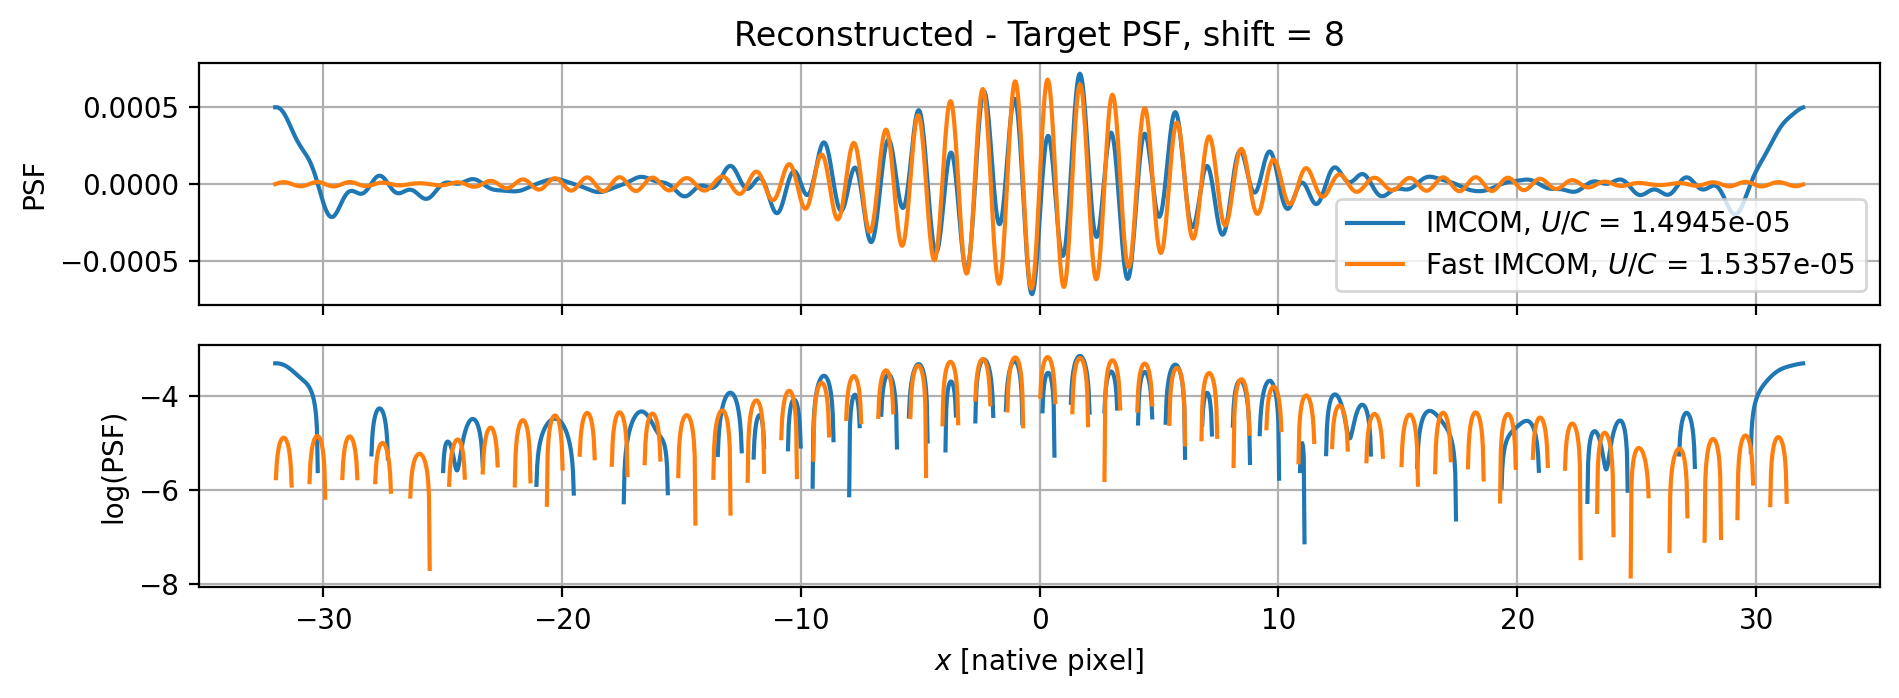

9.387059736520875e-06


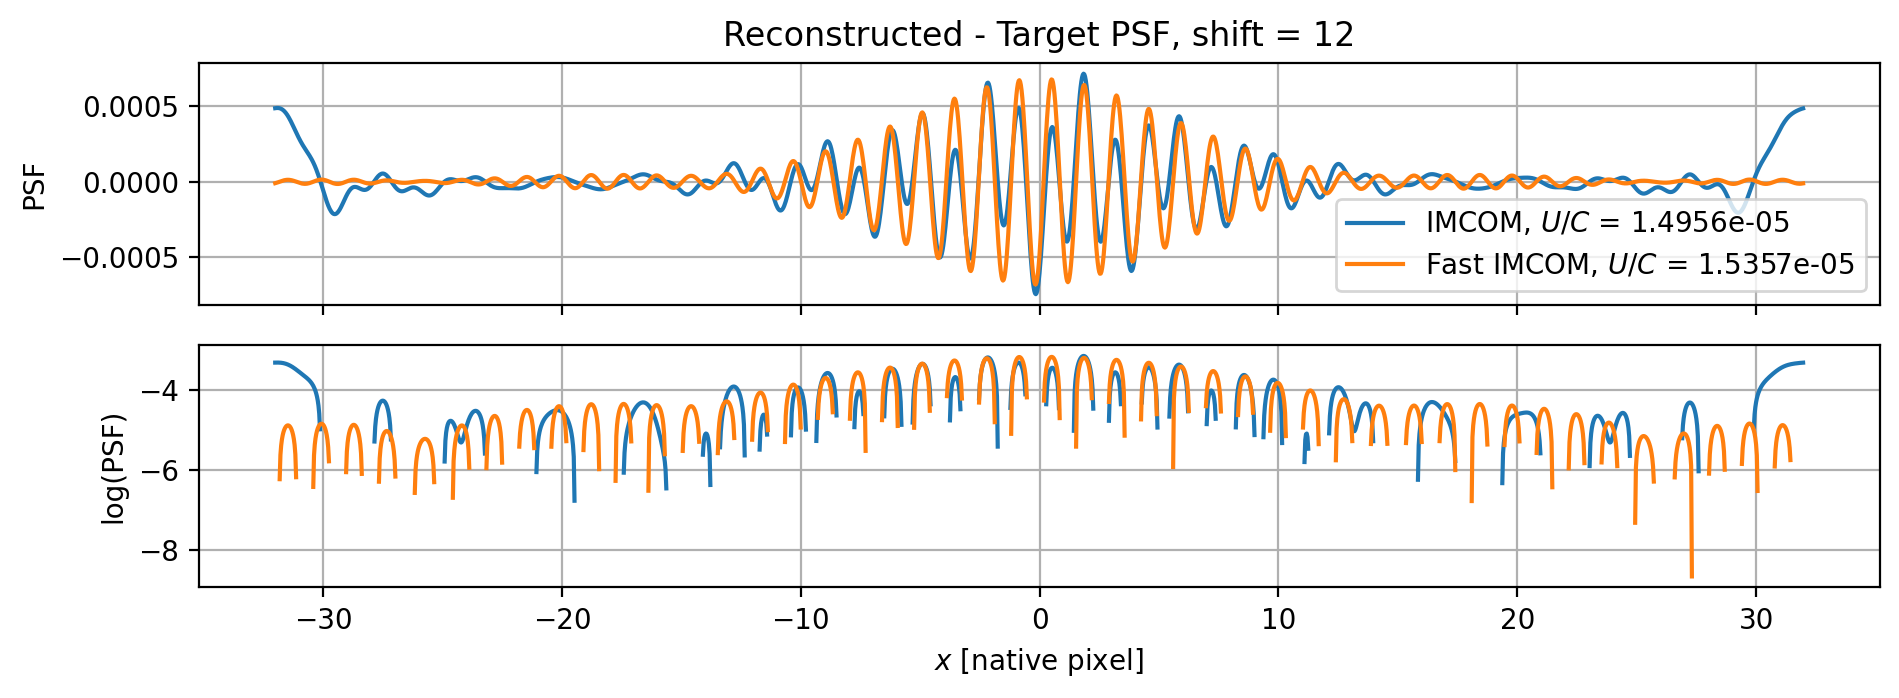

9.396405292849686e-06


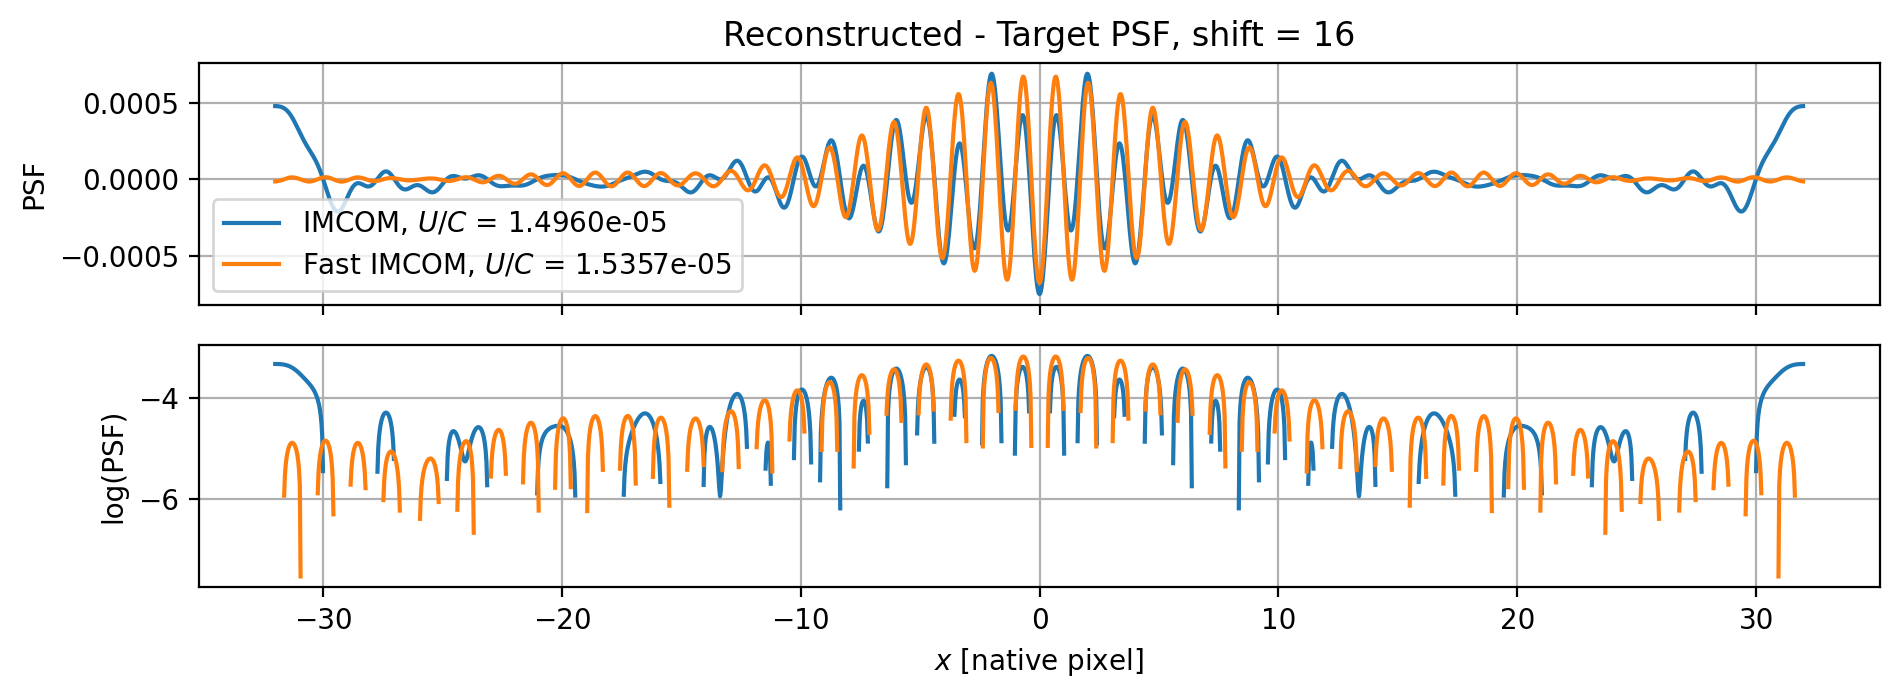

In [7]:
for shift in [0, 4, 8, 12, 16]:  # range(SAMP):
    my_weightu_i = np.zeros_like(weight)
    my_weightu_i[shift::SAMP] = Tmat[shift]
    my_weightu_f = np.zeros_like(weight)
    my_weightu_f[shift::SAMP] = weight[shift::SAMP] * SAMP
    print(np.einsum("ji,j,i->", Amat, Tmat[shift], Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", Bmat[shift], Tmat[shift]) / C + 1)

    if False:  # Option 1: coaddition weights.
        fig, ax = plt.subplots(1, 1, figsize=(9.6, 1.8))
        ax.plot(my_weightu_i[shift::SAMP], label="IMCOM")
        ax.plot(my_weightu_f[shift::SAMP], label="Fast IMCOM")
        ax.set_title(f"{shift = :d}")
        ax.grid()
        plt.show()

    psf_outu_it = np.fft.rfft(np.fft.ifftshift(my_weightu_i))
    psf_outu_i = np.fft.ifftshift(np.fft.irfft(psf_outu_it * psf_inp_t, n=NTOT))
    psf_outu_ft = np.fft.rfft(np.fft.ifftshift(my_weightu_f))
    psf_outu_f = np.fft.ifftshift(np.fft.irfft(psf_outu_ft * psf_inp_t, n=NTOT))
    # print(psf_outu_i.sum(), psf_outu_f.sum(), psf_out.sum())

    if False:  # Option 2: Fourier space.
        fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)
        for i, part in enumerate(["real", "imag"]):
            for psf_outu_t, label in [(psf_outu_it, "IMCOM"),
                                      (psf_outu_ft, "Fast IMCOM")]:
                axs[i].plot(np.fft.rfftfreq(NTOT, d=1/SAMP)[:2*SAMP],
                            getattr(psf_outu_t, part)[:2*SAMP], label=label)
        axs[0].set_title(f"Reconstructed - Target PSF, {shift = :d}")
        format_and_show(fig, axs)

    if True:  # Option 3: real space.
        fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)
        visualize_psf(axs, psf_outu_i-psf_out, f"IMCOM, $U/C$ = {square_norm(psf_outu_i-psf_out)/C:.4e}")
        visualize_psf(axs, psf_outu_f-psf_out, f"Fast IMCOM, $U/C$ = {square_norm(psf_outu_f-psf_out)/C:.4e}")
        axs[0].set_title(f"Reconstructed - Target PSF, {shift = :d}")
        format_and_show(fig, axs)

1.2378351338604432e-05


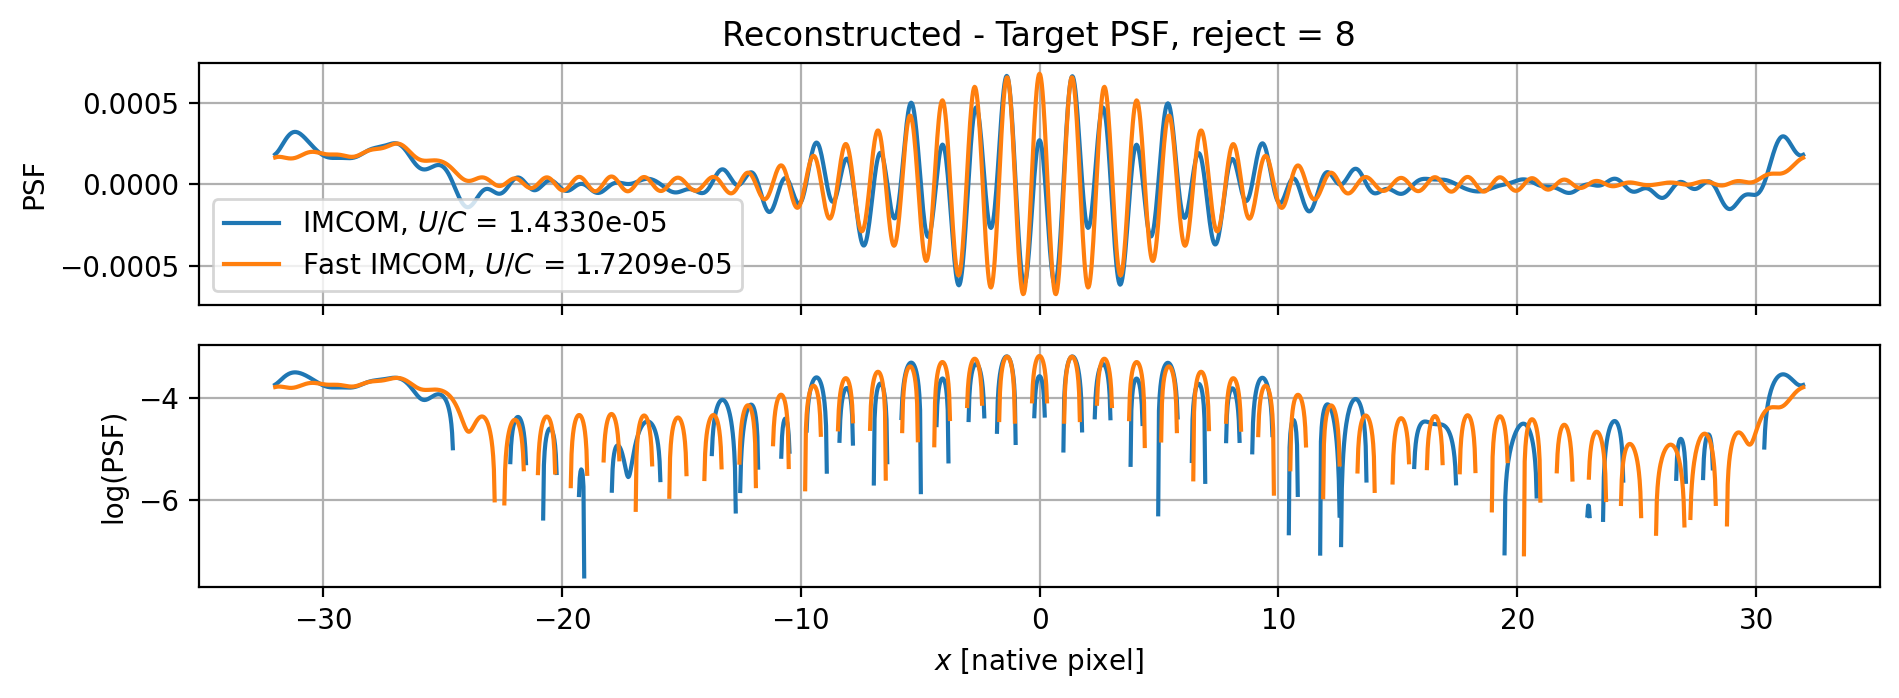

1.5514775977720774e-05


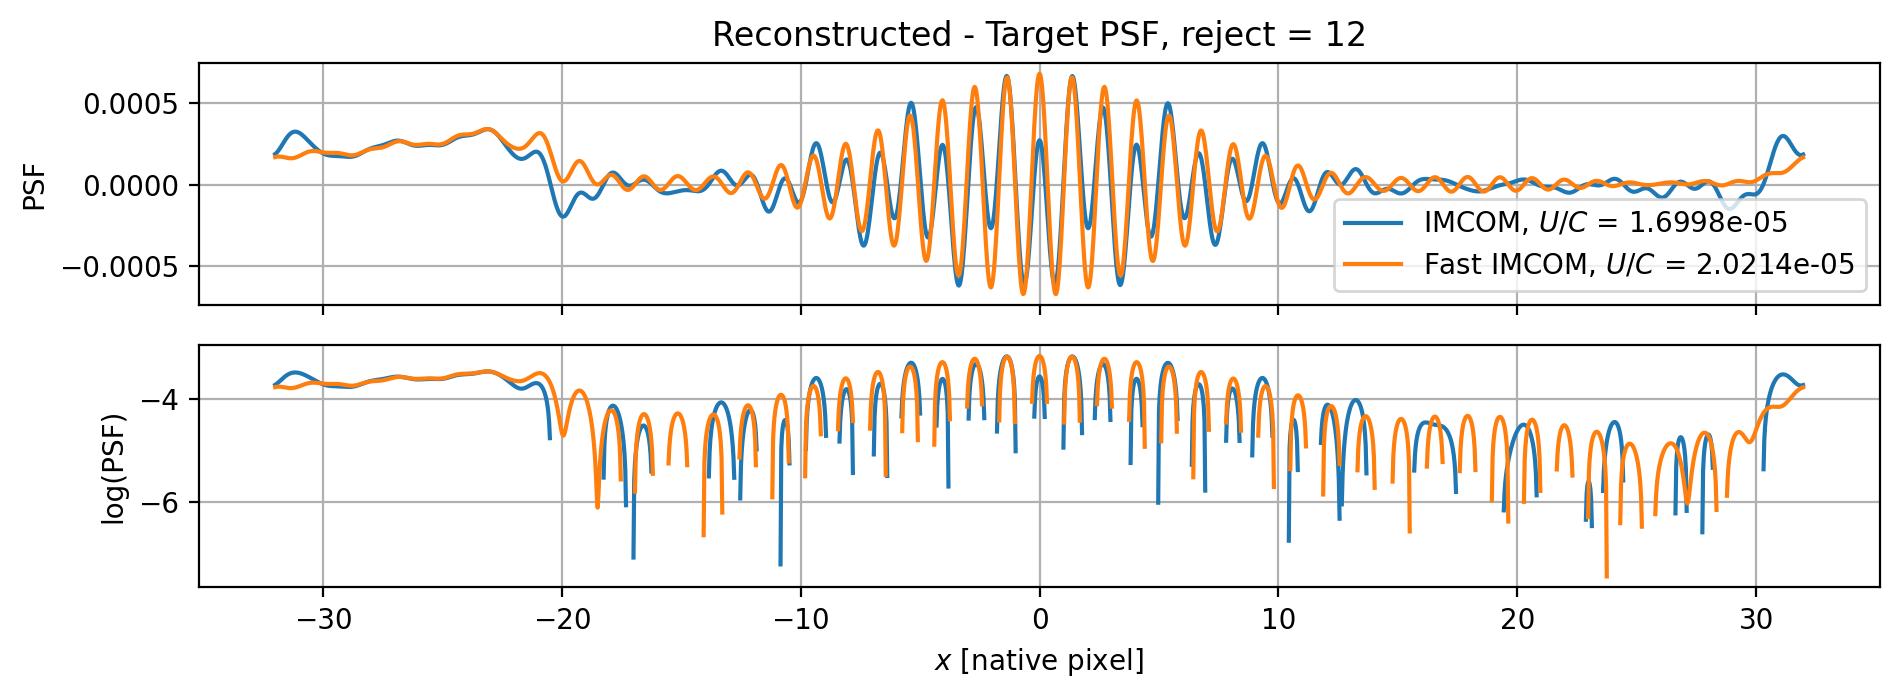

2.2138907209923175e-05


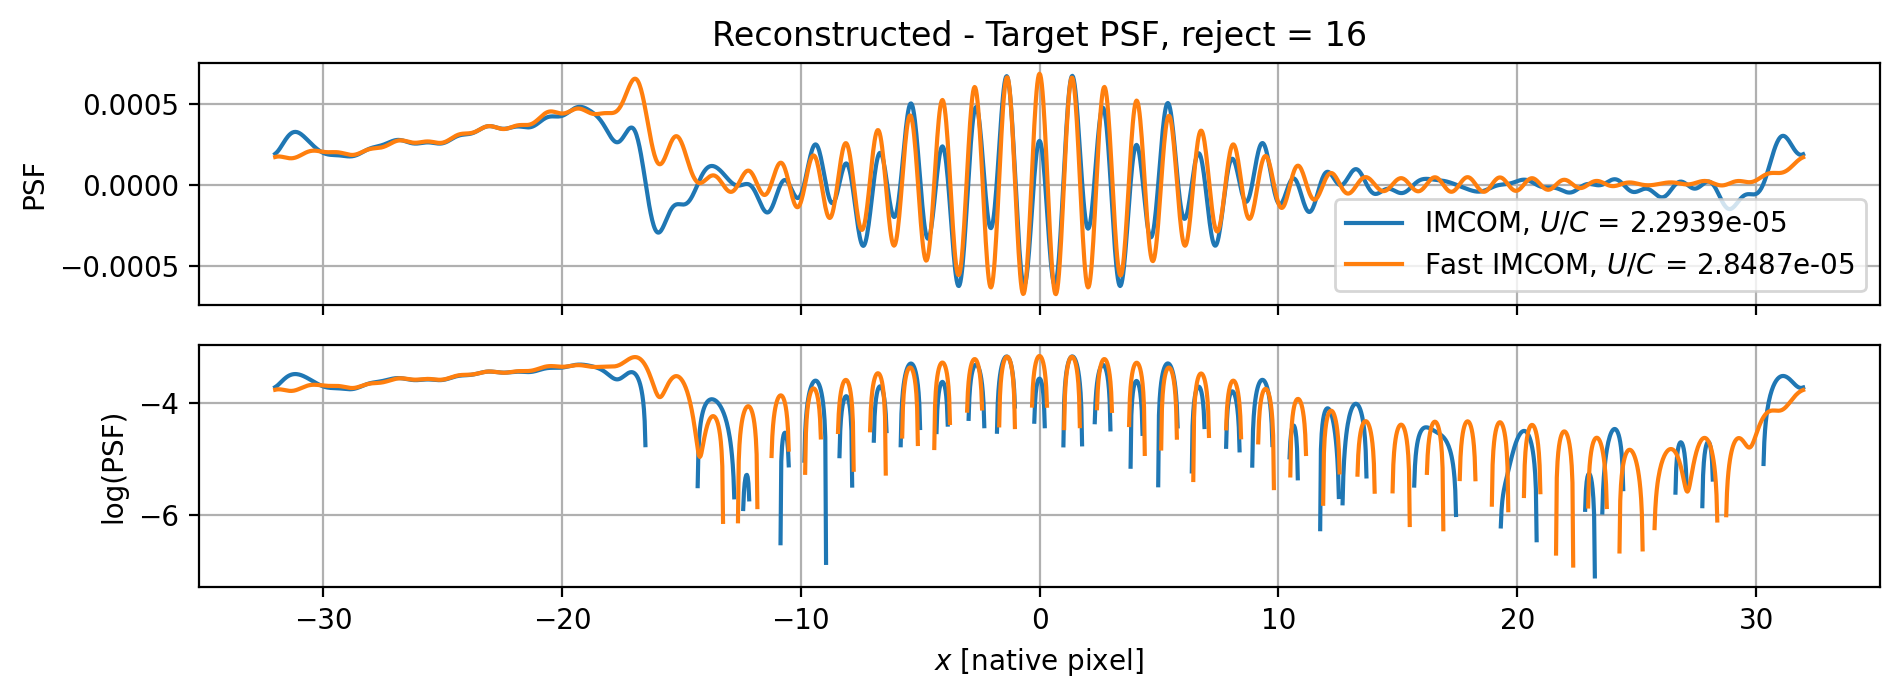

3.942810614776526e-05


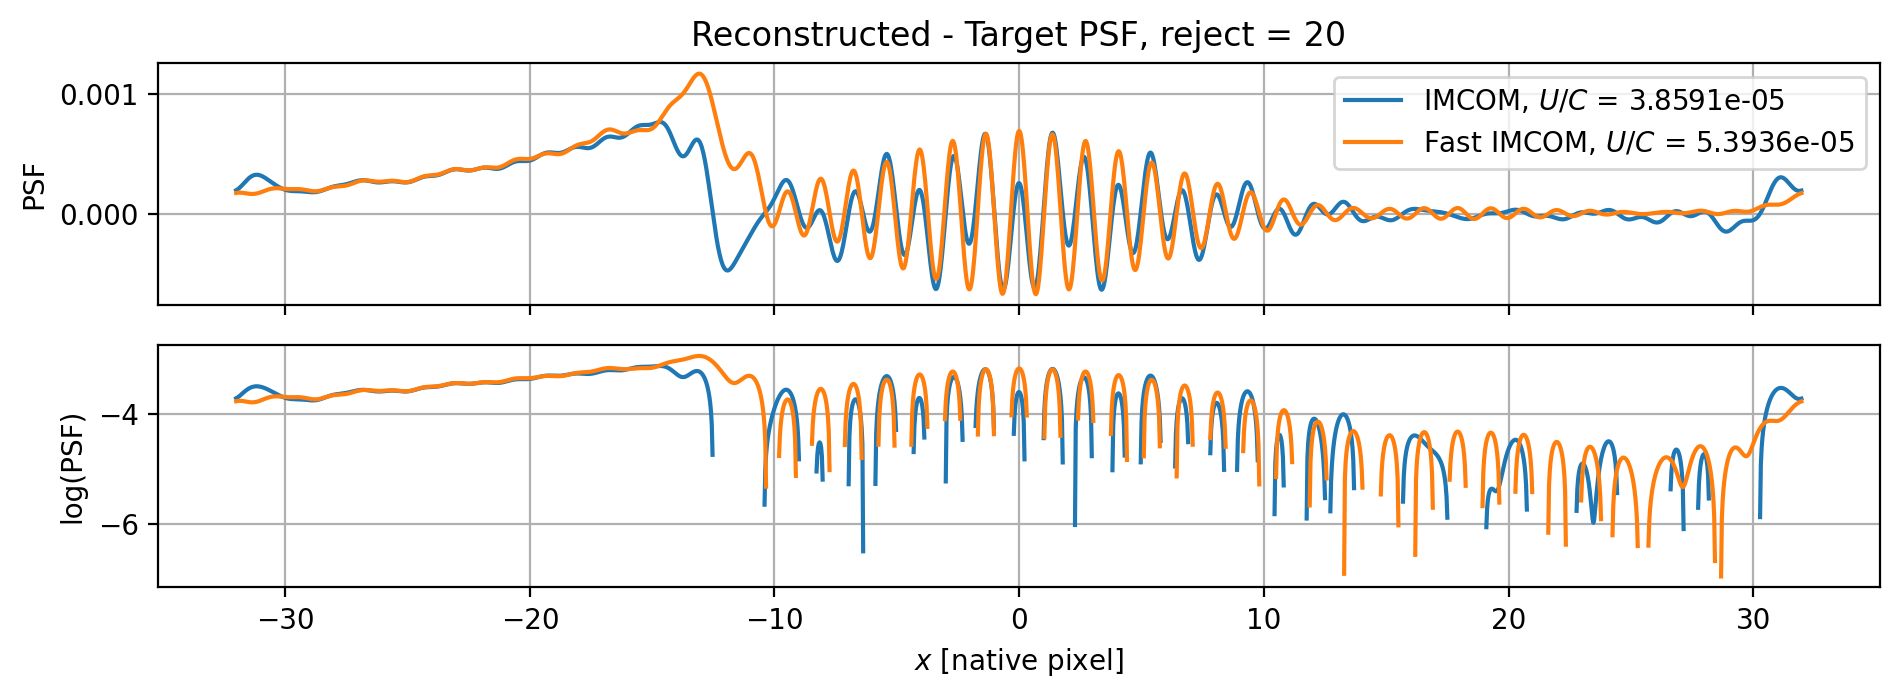

0.0001043527804431843


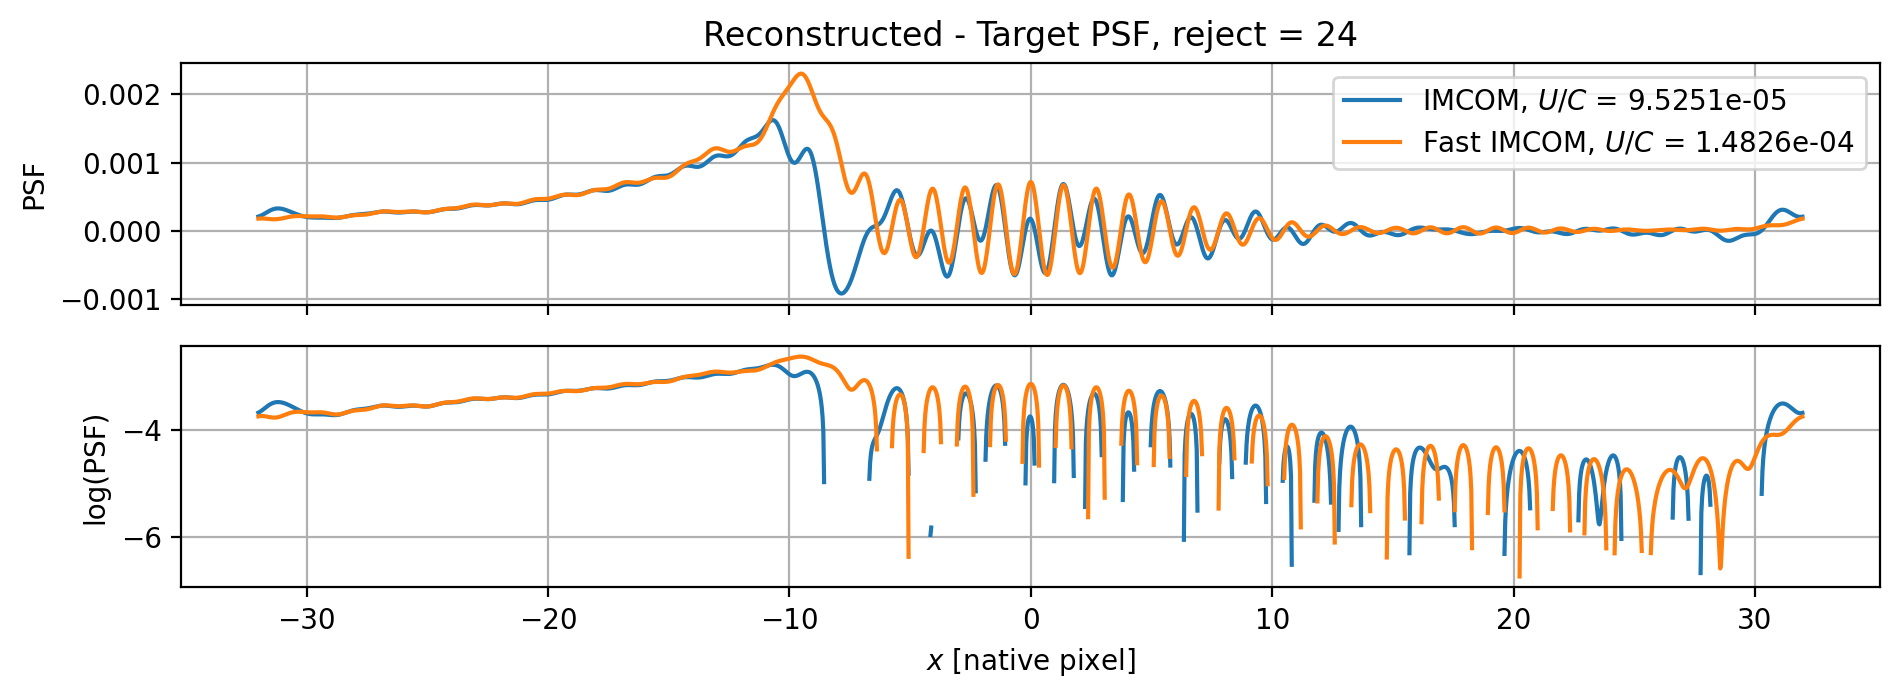

In [8]:
# shift = 0
for reject in [8, 12, 16, 20, 24]:
    my_Amat = Amat[reject:, reject:]
    my_Bmat = Bmat[:, reject:]
    my_Ainv = np.linalg.inv(my_Amat)
    my_Tmat = (my_Ainv @ my_Bmat.T).T
    print(np.einsum("ji,j,i->", my_Amat, my_Tmat[shift], my_Tmat[shift]) / C\
        - 2 * np.einsum("j,j->", my_Bmat[shift], my_Tmat[shift]) / C + 1)

    my_weightu_i = np.zeros_like(weight)
    my_weightu_i[reject*SAMP::SAMP] = my_Tmat[0]
    my_weightu_f = np.zeros_like(weight)
    my_weightu_f[reject*SAMP::SAMP] = weight[reject*SAMP::SAMP] * SAMP
    # Fixing the normalization would only increase the PSF leakage.
    # my_weightu_f *= weight[::SAMP].sum() / weight[reject*SAMP::SAMP].sum()

    # Rejecting input pixels on the right could not fix deviation on the left.
    # my_weightu_f[reject*SAMP:-reject*SAMP:SAMP] =\
    #     weight[reject*SAMP:-reject*SAMP:SAMP] * SAMP
    # Fixing the normalization would increase the PSF leakage.
    # my_weightu_f *= weight[::SAMP].sum() / weight[reject*SAMP::SAMP].sum()

    if False:  # Option 1: coaddition weights.
        fig, ax = plt.subplots(1, 1, figsize=(9.6, 1.8))
        ax.plot(my_weightu_i[::SAMP], label="IMCOM")
        ax.plot(my_weightu_f[::SAMP], label="Fast IMCOM")
        ax.set_title(f"{reject = :d}")
        ax.grid()
        plt.show()

    psf_outu_it = np.fft.rfft(np.fft.ifftshift(my_weightu_i))
    psf_outu_i = np.fft.ifftshift(np.fft.irfft(psf_outu_it * psf_inp_t, n=NTOT))
    psf_outu_ft = np.fft.rfft(np.fft.ifftshift(my_weightu_f))
    psf_outu_f = np.fft.ifftshift(np.fft.irfft(psf_outu_ft * psf_inp_t, n=NTOT))
    # print(psf_outu_i.sum(), psf_outu_f.sum(), psf_out.sum())

    if False:  # Option 2: Fourier space.
        fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)
        for i, part in enumerate(["real", "imag"]):
            for psf_outu_t, label in [(psf_outu_it, "IMCOM"),
                                      (psf_outu_ft, "Fast IMCOM")]:
                axs[i].plot(np.fft.rfftfreq(NTOT, d=1/SAMP)[:2*SAMP],
                            getattr(psf_outu_t, part)[:2*SAMP], label=label)
        axs[0].set_title(f"Reconstructed - Target PSF, {reject = :d}")
        format_and_show(fig, axs)

    if True:  # Option 3: real space.
        fig, axs = plt.subplots(2, 1, figsize=(9.6, 3.6), sharex=True)
        visualize_psf(axs, psf_outu_i-psf_out, f"IMCOM, $U/C$ = {square_norm(psf_outu_i-psf_out)/C:.4e}")
        visualize_psf(axs, psf_outu_f-psf_out, f"Fast IMCOM, $U/C$ = {square_norm(psf_outu_f-psf_out)/C:.4e}")
        axs[0].set_title(f"Reconstructed - Target PSF, {reject = :d}")
        format_and_show(fig, axs)